# Overall performance of module detection methods

In [1]:
import sys
import os
sys.path.insert(0,os.path.abspath("../lib/"))

import json

from util import JSONExtendedEncoder

%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib.pyplot import *

import pandas as pd
import numpy as np

import multiprocessing as mp

from itertools import product

import itertools
import shutil

import os

conf_folder = "conf/"

# Settings

In [2]:
N_JOBS = 1
# N_JOBS = mp.cpu_count()-1

# Running a method on different parameter settings and datasets

Note: If you downloaded the results from zenodo, you don't need to rerun this for "dummy", "agglom", "ica_zscore", "spectral_biclust" and "meanshift"

The following code will explore the parameters of a module detection method on every dataset using a grid-search approach.

If you want to run your own method, you should wrap it into a python function and add its parameters to `conf/paramexplo_blueprints.py`. We will show the whole workflow here for a "dummy"  (but fast) clustering method, which will simply group genes randomly.

Every module detection method is wrapped in a python function (see `scripts/moduledetection.py`)

Because module detection methods usually take a while to run, we generate the files necessary to run a method on the several parameter settings and datasets here. These can then be easily called from the commandline, for example on a computer cluster or locally using GNU `parallel`.

This function will be called by scripts/moduledetection.py , which will save the modules in the correct format along with additional run information (such as running times).

In [3]:
# datasets to run
datasetnames = [
    "ecoli_colombos",
    "ecoli_dream5",
    "yeast_gpl2529",
    "yeast_dream5",
    "synth_ecoli_regulondb",
    "synth_yeast_macisaac",
    "human_tcga",
    "human_gtex",
    "human_seek_gpl5175",
    "ecoli_precise2"
]

# choose the method to evaluate
method_name = "dummy" # use the dummy method to check if everything works correctly
# method_name = "agglom" # this method runs very fast, and has the best performance among clustering methods
# method_name = "ica_zscore" # this method runs very slow, but has approx. the highest performance in the benchmark
# method_name = "spectral_biclust" # top biclustering method
# method_name = "meanshift"

To add your own method, create a function with "your_method_name" in the `lib/clustering.py` file (or any other file as long as it's imported in `scripts/moduledetection.py`.
This function should accept an `E` object (which is a dataframe with genes in columns) and any additional parameters
Then add reasonable parameter setting of your method to `conf/paramexplo_blueprints.py`.

method_name = "your_method_name"

In [4]:
# paramexplo_blueprints.py stores for every method the parameters which will be varied using a grid-search approach.
%run ../conf/paramexplo_blueprints.py
methodblueprint = blueprints[method_name]

In [5]:
methodblueprint

{'staticparams': {'method': 'dummy'},
 'dynparams': {'n': [50, 100, 150, 200]},
 'type': 'moduledetection'}

Generate different parameter settings using a grid-search.

In [6]:
params_folder = "conf/paramexplo/" + method_name + "/"
if os.path.exists("../" + params_folder):
    shutil.rmtree("../" + params_folder)
os.makedirs("../" + params_folder)

methodsettings = []
method_locations = []
i = 0
for dynparam_combination in list(itertools.product(*[methodblueprint["dynparams"][param] for param in sorted(methodblueprint["dynparams"].keys())])):
    method = {"params":{}}
    method["params"] = methodblueprint["staticparams"].copy()
    method["params"].update(dict(zip(sorted(methodblueprint["dynparams"].keys()), dynparam_combination)))
    method["location"] = params_folder + str(i) + ".json"
    method["seed"] = 0

    methodsettings.append(method)

    json.dump(method, open("../" + method["location"], "w"), cls=JSONExtendedEncoder)

    method_locations.append(method["location"])

    i+=1

Now combine the different parameter settings and datasets. Then generate the different python commands to run every parameter setting and dataset in parallel.

In [7]:
settings_name = "paramexplo/{method_name}".format(method_name = method_name)
settings = []
for datasetname in datasetnames:
    for setting_ix, methodsetting in enumerate(methodsettings):
        settingid = datasetname + "_" + str(setting_ix)
        settings.append({
            "dataset_location":"conf/datasets/" + datasetname + ".json",
            "dataset_name":datasetname,
            "method_location":methodsetting["location"],
            "output_folder":"results/" + methodblueprint["type"] + "/{settings_name}/{settingid}/".format(settings_name=settings_name, settingid=settingid),
            "settingid":settingid
        })
json.dump(settings, open("../conf/settings/{settings_name}.json".format(settings_name=settings_name), "w"))

In [8]:
settings_dataset = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["dataset_location"]))["params"]) for setting in settings])
settings_method = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["method_location"]))["params"]) for setting in settings])

In [9]:
commands = ""
for i, setting in enumerate(settings):
    #commands += "python scripts/moduledetection.py {method_location} {dataset_location} {output_folder} 0 test\n".format(**setting)
    commands += "python3 scripts/" + methodblueprint["type"] + ".py {method_location} {dataset_location} {output_folder}\n".format(**setting)

commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs("../" + os.path.dirname(commands_location), exist_ok=True)
with open("../" + commands_location, "w") as outfile:
    outfile.write(commands)
commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs(os.path.dirname("../tmp/" + commands_location), exist_ok=True)
with open("../tmp/" + commands_location, "w") as outfile:
    outfile.write(commands)
    
#script_location = generate_batchcode(commands_location, settings_name, len(settings), {"memory":"10G", "numcores":1}, "biclust_comp2")

# this command can be used on most linux computers to run the different parameter settings in parallel
print("parallel -j 4 -a " + commands_location)

parallel -j 4 -a tmp/paramexplo/dummy.txt


# Evaluating the method

In [10]:
from modulescomparison import ModevalKnownmodules, ModevalCoverage

Note: If you downloaded the results from zenodo, you don't need to rerun this for "dummy", "agglom", "ica_zscore", "spectral_biclust" and "meanshift"

## By comparing with known modules

Evaluate by comparing with known modules

In [11]:
# create pool of processors
if "pool" in locals().keys():
    pool.close()
pool = mp.Pool(N_JOBS)

In [12]:
settings_filtered = [setting for setting in settings if not setting["dataset_name"].startswith("human")] # only evaluate non-human datasets
modeval = ModevalKnownmodules(settings_filtered, baseline = True)

In [13]:
modeval.run(pool)
modeval.save(settings_name)

In [14]:
modeval.load(settings_name)

In [15]:
modeval.scores

,recovery,relevance,F1rr,recall,precision,F1rp,F1rprr,F1rr_permuted,F1rp_permuted,F1rprr_permuted,settingid,knownmodules_name,regnet_name,goldstandard,runningtime
0,0.071737,0.075580,0.073609,0.007794,0.006311,0.006975,0.012742,0.997017,1.002808,0.999904,ecoli_colombos_0,mcl2,ecoli_regulondb,ecoli_regulondb#mcl2,0.000859
1,0.066761,0.062729,0.064683,0.009213,0.003203,0.004753,0.008856,0.880532,0.564140,0.687690,ecoli_colombos_0,minimal,ecoli_regulondb,ecoli_regulondb#minimal,0.000859
2,0.068015,0.063922,0.065905,0.005290,0.006067,0.005652,0.010411,0.877625,0.805378,0.839951,ecoli_colombos_0,ap3,ecoli_regulondb,ecoli_regulondb#ap3,0.000859
3,0.060492,0.063724,0.062066,0.007009,0.004138,0.005204,0.009603,0.928783,0.772637,0.843545,ecoli_colombos_0,tc1,ecoli_regulondb,ecoli_regulondb#tc1,0.000859
4,0.059497,0.062546,0.060983,0.006018,0.004245,0.004978,0.009205,0.958662,0.925666,0.941875,ecoli_colombos_0,mcl3,ecoli_regulondb,ecoli_regulondb#mcl3,0.000859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,0.083196,0.083035,0.083116,0.011546,0.004080,0.006030,0.011244,1.016778,0.674480,0.810990,synth_yeast_macisaac_3,strict,yeast_macisaac,yeast_macisaac#strict,0.001078
352,0.053810,0.045530,0.049325,0.011925,0.001622,0.002855,0.005397,0.671197,0.338996,0.450475,ecoli_precise2_0,minimal,ecoli_regulondb,ecoli_regulondb#minimal,0.001533
353,0.061029,0.060271,0.060648,0.015375,0.001311,0.002416,0.004647,0.825759,0.286905,0.425850,ecoli_precise2_1,minimal,ecoli_regulondb,ecoli_regulondb#minimal,0.001477
354,0.066682,0.065946,0.066312,0.017343,0.001207,0.002257,0.004365,0.902889,0.268055,0.413383,ecoli_precise2_2,minimal,ecoli_regulondb,ecoli_regulondb#minimal,0.001554


## Using the coverage of regulators

In [16]:
# create pool of processors
if "pool" in locals().keys():
    pool.close()
pool = mp.Pool(N_JOBS)

/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9

/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9

/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miltondp/software/miniconda3/envs/moduledetection_evaluation/lib/python3.9

In [17]:
settings_filtered = [setting for setting in settings if setting["dataset_name"].startswith("human")] # only evaluate human datasets
modeval = ModevalCoverage(settings_filtered, baseline = True)

In [18]:
modeval.run(pool)
modeval.save(settings_name)

Evaluating a total of 12 settings.


In [19]:
modeval.load(settings_name)

In [20]:
modeval.scores

,aucodds,aucodds_permuted,settingid,goldstandard,runningtime
0,0.000529,0.019975,human_tcga_0,regcircuit,0.001955
1,0.001403,0.052938,human_tcga_1,regcircuit,0.001985
2,0.003376,0.127380,human_tcga_2,regcircuit,0.002034
3,0.004871,0.183811,human_tcga_3,regcircuit,0.002024
4,0.002846,0.107382,human_gtex_0,regcircuit,0.001711
5,0.004387,0.165533,human_gtex_1,regcircuit,0.001822
6,0.002814,0.106199,human_gtex_2,regcircuit,0.001832
7,0.004159,0.156934,human_gtex_3,regcircuit,0.001799
8,0.000614,0.023176,human_seek_gpl5175_0,regcircuit,0.001550
9,0.004626,0.174572,human_seek_gpl5175_1,regcircuit,0.001521


## Comparing with other methods

This compares all methods as was done in the paper. Essentially, we will calculate test scores by choosing optimal parameters from one dataset and check how they performed on another dataset. We only compare between [ecoli, yeast], [synthetic] and [human] datasets.

In [21]:
def score_method(scores):
    methodscores = []
    for ((datasetoi, goldstandardoi), scoresoi), ((datasetor, goldstandardor), scoresor) in product(scores.groupby(["datasetname", "goldstandard"]), scores.groupby(["datasetname", "goldstandard"])):
        if (datasetor.split("_")[0]=="synth" and datasetoi.split("_")[0]!="synth") or (datasetor.split("_")[0]!="synth" and datasetoi.split("_")[0]=="synth"):
            continue
                
        if (goldstandardoi.split("#")[-1] != goldstandardor.split("#")[-1]):
            if (datasetoi.startswith("human") != datasetor.startswith("human")):
                ""
            else:
                continue

        # find the most optimal method parameters in the reference dataset (test dataset)
        bestparams = scoresor[paramsoi].loc[scoresor["score"].idxmax()]
        
        try:
            rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]
        except:
            print(scoresoi)

        # now find these parameters in the dataset of interest (training dataset)
        rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]
            
        if len(rowids) == 0:
            print("parameters could not be matched!!", datasetoi, datasetor)
            print(bestparams)
            print([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()])
        if len(rowids) > 1:
            print(datasetoi)
            print("multiple matched parameters")
            print(scoresoi.loc[rowids][paramsoi])

        methodscores.append({
            "datasetoi":datasetoi,
            "datasetor":datasetor,
            "score":scoresoi.loc[rowids,"score"].max(),
            "method":methodname,
            "goldstandardoi":goldstandardoi,
            "goldstandardor":goldstandardor,
            "ofinterest":datasetoi + "#" + goldstandardoi,
            "ofreference":datasetor + "#" + goldstandardor,
            "runningtime":scoresoi.loc[rowids, "runningtime"].mean() if "runningtime" in scoresoi.columns else 0,
            "moduledef":scoresoi.loc[rowids, "moduledef"].tolist()[0],
            "organismoi":scoresoi.loc[rowids, "organism"].tolist()[0],  
        })
    
    return pd.DataFrame(methodscores)

In [22]:
methodnames = ["dummy", "agglom", "ica_zscore", "spectral_biclust", "meanshift"]

In [23]:
finalscores = []
for methodname in methodnames:
    settings_name = "paramexplo/" + methodname
    settings = json.load(open("../conf/settings/{}.json".format(settings_name)))
    settings_dataset = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["dataset_location"]))["params"]) for setting in settings])
    settings_method = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["method_location"]))["params"]) for setting in settings])
    
    print(methodname)
    paramsoi = methodparamsoi[methodname]

    scores = pd.DataFrame()
    
    modeval = ModevalKnownmodules(settings_name)
    modeval.load(settings_name)
    modeval.scores["score"] = modeval.scores["F1rprr_permuted"]
    modeval.scores["moduledef"] = [modulesname if modulesname in ["minimal", "strict"] else "interconnected" for modulesname in modeval.scores["knownmodules_name"]]
    modeval.scores = modeval.scores.merge(settings_dataset, on="settingid").merge(settings_method, on="settingid")
    scores = scores.append(modeval.scores, ignore_index=True)
    
    modeval = ModevalCoverage(settings_name)
    modeval.load(settings_name)
    modeval.scores["score"] = modeval.scores["aucodds_permuted"]
    modeval.scores = modeval.scores.merge(settings_dataset, on="settingid").merge(settings_method, on="settingid")
    scores = scores.append(modeval.scores, ignore_index=True)
    
    methodscores = score_method(scores)
    
    methodscores["organismnetoi"] = [dataset.split("_")[0] for dataset in methodscores["goldstandardoi"]]
    methodscores["organismnetor"] = [dataset.split("_")[0] for dataset in methodscores["goldstandardor"]]

    finalscores.append(methodscores)
finalscores = pd.concat(finalscores, ignore_index=True)

dummy
agglom
ica_zscore
spectral_biclust
meanshift


The final scores contains all the comparisons we made, together with a final score in the score column:

In [24]:
finalscores

,datasetoi,datasetor,score,method,goldstandardoi,goldstandardor,ofinterest,ofreference,runningtime,moduledef,organismoi,organismnetoi,organismnetor
0,ecoli_colombos,ecoli_colombos,1.117668,dummy,ecoli_regulondb#ap1,ecoli_regulondb#ap1,ecoli_colombos#ecoli_regulondb#ap1,ecoli_colombos#ecoli_regulondb#ap1,0.001247,interconnected,ecoli,ecoli,ecoli
1,ecoli_colombos,ecoli_dream5,1.117668,dummy,ecoli_regulondb#ap1,ecoli_regulondb#ap1,ecoli_colombos#ecoli_regulondb#ap1,ecoli_dream5#ecoli_regulondb#ap1,0.001247,interconnected,ecoli,ecoli,ecoli
2,ecoli_colombos,human_gtex,1.076810,dummy,ecoli_regulondb#ap1,regcircuit,ecoli_colombos#ecoli_regulondb#ap1,human_gtex#regcircuit,0.001226,interconnected,ecoli,ecoli,regcircuit
3,ecoli_colombos,human_seek_gpl5175,0.896559,dummy,ecoli_regulondb#ap1,regcircuit,ecoli_colombos#ecoli_regulondb#ap1,human_seek_gpl5175#regcircuit,0.000900,interconnected,ecoli,ecoli,regcircuit
4,ecoli_colombos,human_tcga,0.896559,dummy,ecoli_regulondb#ap1,regcircuit,ecoli_colombos#ecoli_regulondb#ap1,human_tcga#regcircuit,0.000900,interconnected,ecoli,ecoli,regcircuit
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,yeast_gpl2529,human_tcga,1.247844,meanshift,yeast_sisima#tc3,regcircuit,yeast_gpl2529#yeast_sisima#tc3,human_tcga#regcircuit,1014.925722,interconnected,yeast,yeast,regcircuit
4316,yeast_gpl2529,yeast_dream5,0.000000,meanshift,yeast_sisima#tc3,yeast_macisaac#tc3,yeast_gpl2529#yeast_sisima#tc3,yeast_dream5#yeast_macisaac#tc3,133.666315,interconnected,yeast,yeast,yeast
4317,yeast_gpl2529,yeast_dream5,0.000000,meanshift,yeast_sisima#tc3,yeast_sisima#tc3,yeast_gpl2529#yeast_sisima#tc3,yeast_dream5#yeast_sisima#tc3,192.197864,interconnected,yeast,yeast,yeast
4318,yeast_gpl2529,yeast_gpl2529,1.419103,meanshift,yeast_sisima#tc3,yeast_macisaac#tc3,yeast_gpl2529#yeast_sisima#tc3,yeast_gpl2529#yeast_macisaac#tc3,248.151631,interconnected,yeast,yeast,yeast


In [25]:
finalscores.query("method == 'ica_zscore'")

,datasetoi,datasetor,score,method,goldstandardoi,goldstandardor,ofinterest,ofreference,runningtime,moduledef,organismoi,organismnetoi,organismnetor
1728,ecoli_colombos,ecoli_colombos,6.351389,ica_zscore,ecoli_regulondb#ap1,ecoli_regulondb#ap1,ecoli_colombos#ecoli_regulondb#ap1,ecoli_colombos#ecoli_regulondb#ap1,45.998550,interconnected,ecoli,ecoli,ecoli
1729,ecoli_colombos,ecoli_dream5,6.242537,ica_zscore,ecoli_regulondb#ap1,ecoli_regulondb#ap1,ecoli_colombos#ecoli_regulondb#ap1,ecoli_dream5#ecoli_regulondb#ap1,26.985090,interconnected,ecoli,ecoli,ecoli
1730,ecoli_colombos,human_gtex,5.215639,ica_zscore,ecoli_regulondb#ap1,regcircuit,ecoli_colombos#ecoli_regulondb#ap1,human_gtex#regcircuit,74.804224,interconnected,ecoli,ecoli,regcircuit
1731,ecoli_colombos,human_seek_gpl5175,5.712158,ica_zscore,ecoli_regulondb#ap1,regcircuit,ecoli_colombos#ecoli_regulondb#ap1,human_seek_gpl5175#regcircuit,75.714326,interconnected,ecoli,ecoli,regcircuit
1732,ecoli_colombos,human_tcga,6.119170,ica_zscore,ecoli_regulondb#ap1,regcircuit,ecoli_colombos#ecoli_regulondb#ap1,human_tcga#regcircuit,63.381258,interconnected,ecoli,ecoli,regcircuit
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,yeast_gpl2529,human_tcga,3.971098,ica_zscore,yeast_sisima#tc3,regcircuit,yeast_gpl2529#yeast_sisima#tc3,human_tcga#regcircuit,82.797954,interconnected,yeast,yeast,regcircuit
2588,yeast_gpl2529,yeast_dream5,4.220220,ica_zscore,yeast_sisima#tc3,yeast_macisaac#tc3,yeast_gpl2529#yeast_sisima#tc3,yeast_dream5#yeast_macisaac#tc3,9.789663,interconnected,yeast,yeast,yeast
2589,yeast_gpl2529,yeast_dream5,4.253741,ica_zscore,yeast_sisima#tc3,yeast_sisima#tc3,yeast_gpl2529#yeast_sisima#tc3,yeast_dream5#yeast_sisima#tc3,11.933597,interconnected,yeast,yeast,yeast
2590,yeast_gpl2529,yeast_gpl2529,4.220220,ica_zscore,yeast_sisima#tc3,yeast_macisaac#tc3,yeast_gpl2529#yeast_sisima#tc3,yeast_gpl2529#yeast_macisaac#tc3,9.789663,interconnected,yeast,yeast,yeast


We add weights to the test scores, because e.g. E. coli datasets will have many more test scores as there are more "reference" datasets available.

In [26]:
def add_weights(scores):
    weights = []
    scores["moduledef"] = scores["moduledef"].fillna("")
    for organismoi, subscores in scores.groupby("organismoi"):
        moduledef_weights = 1/subscores.groupby("moduledef")["score"].count()
        for moduledef, weight in moduledef_weights.items():
            weights.append({
                    "organism":organismoi,
                    "moduledef":moduledef,
                    "weight":weight / len(moduledef_weights)
                })
    weights = pd.DataFrame(weights).set_index(["organism", "moduledef"])["weight"]
    
    scores["weight"] = weights.loc[pd.Index(scores[["organismoi", "moduledef"]])].tolist()
    
    return scores

In [27]:
trainingscores_ = add_weights(finalscores.loc[(finalscores["ofinterest"] == finalscores["ofreference"])])
testscores_ = add_weights(finalscores.loc[(finalscores["ofinterest"] != finalscores["ofreference"]) & (finalscores["organismnetoi"] != finalscores["organismnetor"])])

/tmp/ipykernel_90758/4089861130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["moduledef"] = scores["moduledef"].fillna("")
/tmp/ipykernel_90758/4089861130.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["weight"] = weights.loc[pd.Index(scores[["organismoi", "moduledef"]])].tolist()


Do a weighted mean:

In [28]:
trainingscores = trainingscores_.groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))
testscores = testscores_.groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))

In [29]:
testscores_.to_csv("../results/testscores_.tsv", sep="\t")
trainingscores_.to_csv("../results/trainingscores_.tsv", sep="\t")

In [30]:
trainingscores

method
agglom              7.854651
dummy               0.700174
ica_zscore          9.831074
meanshift           5.134528
spectral_biclust    7.839478
dtype: float64

In [31]:
testscores

method
agglom              6.931690
dummy               0.561661
ica_zscore          8.116071
meanshift           2.264274
spectral_biclust    5.887325
dtype: float64

Visualization of overall training and test scores:

In [32]:
import matplotlib as mpl

''

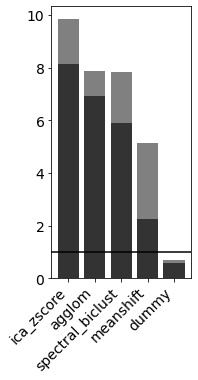

In [33]:
# A bar chart is actually not the ideal representation here, given that we're working with ratios. 
# This way of plotting is kept here because it most closely resembles that of the paper.

fig, ax = subplots(figsize=(len(trainingscores)/2, 5))

methodorder = testscores.sort_values(ascending=False).index

ax.axhline(1, color = "black")
ax.bar(range(len(methodorder)), trainingscores[methodorder], color="grey")
ax.bar(range(len(methodorder)), testscores[methodorder], color="#333333")
ax.set_xticks(np.arange(len(methodorder)))
ax.set_xticklabels(methodorder, rotation=45, ha="right", va="top")
ax.tick_params(labelsize=14)
""

''

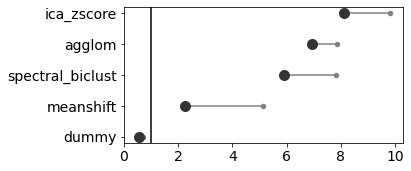

In [34]:
# A better way to visualize the data would be dotplot

fig, ax = subplots(figsize=(5, len(trainingscores)/2))

methodorder = testscores.sort_values(ascending=True).index

ax.axvline(1, color = "black")
for y, method in enumerate(methodorder):
    ax.plot([trainingscores[method], testscores[method]], [y, y], zorder = 0, color = "grey")
ax.scatter(trainingscores[methodorder], range(len(methodorder)), color="grey", s = 20)
ax.scatter(testscores[methodorder], range(len(methodorder)), color="#333333", s = 100)
ax.set_yticks(np.arange(len(methodorder)))
ax.set_yticklabels(methodorder)
ax.tick_params(labelsize=14)
ax.set_xlim([0, ax.get_xlim()[1]])
""

You can also calculate scores for a particular organism, ...:

In [35]:
trainingscores = trainingscores_.query("organismoi == 'ecoli'").groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))
testscores = testscores_.query("organismoi == 'ecoli'").groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))

''

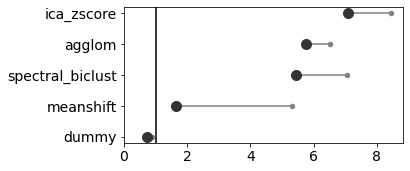

In [36]:
# A better way to visualize the data would be dotplot

fig, ax = subplots(figsize=(5, len(trainingscores)/2))

methodorder = testscores.sort_values(ascending=True).index

ax.axvline(1, color = "black")
for y, method in enumerate(methodorder):
    ax.plot([trainingscores[method], testscores[method]], [y, y], zorder = 0, color = "grey")
ax.scatter(trainingscores[methodorder], range(len(methodorder)), color="grey", s = 20)
ax.scatter(testscores[methodorder], range(len(methodorder)), color="#333333", s = 100)
ax.set_yticks(np.arange(len(methodorder)))
ax.set_yticklabels(methodorder)
ax.tick_params(labelsize=14)
ax.set_xlim([0, ax.get_xlim()[1]])
""